In [ ]:
!pip install control
!pip install slycot

  Using cached slycot-0.6.1.tar.gz (3.1 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for slycot: filename=slycot-0.6.1-cp312-cp312-linux_x86_64.whl size=2036177 sha256=dbd13381756de7774118f00e8c83249b0f6433c04cf391c178f43c65efb43ac8
  Stored in directory: /root/.cache/pip/wheels/6d/bc/2e/f8962440bb4fd23918c27fa8f52c88def8c7fc3aabd9bb2b6a
Successfully built slycot


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy import linalg
import control
from numpy.linalg import matrix_rank
from numpy import linalg as LA
import matplotlib.pyplot as plt
from control.matlab import *
from numpy.linalg import inv

### Define system dynamics

In [ ]:
class VehicleSteering:
    def __init__(self):
        self.A = np.array([[0, 1.],\
                           [0, 0]])

        self.B = np.expand_dims(np.array([0, 1.0]), 1) #2x1

        self.C = np.expand_dims( np.array([1.0, 0]) , 0 ) #1x2

In [ ]:
# Define the vehicle steering system
car = VehicleSteering()

In [ ]:
# Compute eigenvalues of A
eig, eigen_vector = LA.eig(car.A)
print(eig)

[0. 0.]


### LQR for state-feedback controller

In [ ]:
# State and Control Cost Matrix
Q_x = np.diag([2., 1.])
Q_u = np.diag([2.])

# P : Solution to Riccati Equation
P = linalg.solve_continuous_are(car.A, car.B, Q_x, Q_u)

# K : LQR Gain K = Q_u^{-1}B^TP
K_lqr = inv(Q_u) @ (car.B).T @ P
print('[compute_K] Optimal controller gain K value=', K_lqr)

[compute_K] Optimal controller gain K value= [[1.         1.58113883]]


In [ ]:
# Define the closed-loop state feedback system
B_d1 = car.B@K_lqr
B_d2 = car.B
B_d = np.hstack((B_d1, B_d2))

car_lqr = control.ss(car.A-car.B*K_lqr, B_d, car.C, 0)

In [ ]:
# Simulate the system
t = np.linspace(0, 20, 1001)

x_d = np.matrix([1.0*np.sin(t), 1.0*np.cos(t)]).T
print('x_d shape', np.shape(x_d))

u_d = np.matrix([-1.0*np.sin(t)]).T
print('u_d shape', np.shape(u_d))

r = np.hstack((x_d, u_d))
print('r shape', np.shape(r))

[y_lqr, t_lqr, x_lqr] = lsim(car_lqr, r, t, X0=[0, 5]);

x_d shape (1001, 2)
u_d shape (1001, 1)
r shape (1001, 3)


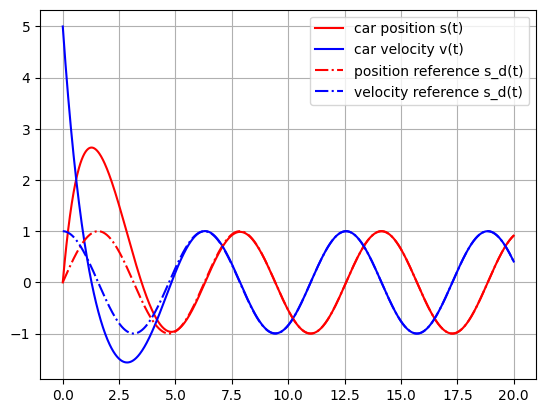

In [ ]:
plt.plot(t, x_lqr[:, 0], 'r-', label = 'car position s(t)')
plt.plot(t, x_lqr[:, 1], 'b-', label = 'car velocity v(t)')
plt.plot(t, x_d[:, 0], 'r-.', label = 'position reference s_d(t)')
plt.plot(t, x_d[:, 1], 'b-.', label = 'velocity reference s_d(t)')
plt.legend(loc='upper right')
plt.grid()

### Kalman Filter

In [ ]:
# State disturbance and measurement noise
mean_wd = [0, 0]
mean_wn = [0]
R_v = np.diag([0.1, 0.1])
R_w = np.diag([0.01])

# P_o : Solution to Riccati Equation
P_o = linalg.solve_continuous_are(car.A.T, car.C.T, R_v, R_w)

# L : Kalman filter gain L = P_oC^T(R_w)^{-1}
L_f = P_o @ car.C.T @ inv(R_w)

print('[compute_L] Kalman Filter Gain L value=', L_f)

[compute_L] Kalman Filter Gain L value= [[4.04036574]
 [3.16227766]]


### LQG (combine Optimal Controller and Optimal Estimator)

In [ ]:

## Define the output feedback system
Alqg = Alqg = np.block([
    [car.A - car.B @ K_lqr, car.B @ K_lqr],
    [np.zeros((2,2)),      car.A - L_f @ car.C]])

I = np.eye(2)

Blqg = np.block([
    [car.B @ K_lqr,  car.B,  I,  np.zeros((2,1))],
    [np.zeros((2,2)), np.zeros((2,1)), I, -L_f]
])

Clqg = np.block([ [car.C, np.zeros((1,2))] ])

Dlqg = 0

car_lqg = control.ss(Alqg, Blqg, Clqg, Dlqg)

In [ ]:
# Simulate the system
T = 1001
t = np.linspace(0, 20, 1001)
d_v = np.random.multivariate_normal(mean_wd, R_v, T) #generate Gaussian process noise
d_w = np.random.multivariate_normal(mean_wn, R_w, T) #generate Gaussian measurement noise

# Simulate the output feedback system and obtain
u = np.hstack([x_d, u_d, d_v, d_w])

X0_lqg = np.array([0, 5, 0, 5])   # [x; e] = [s, v, e1, e2]

[y_lqg, t_lqg, x_lqg] = [y_lqr, t_lqr, x_lqr] = lsim(car_lqg, u, t, X0_lqg);

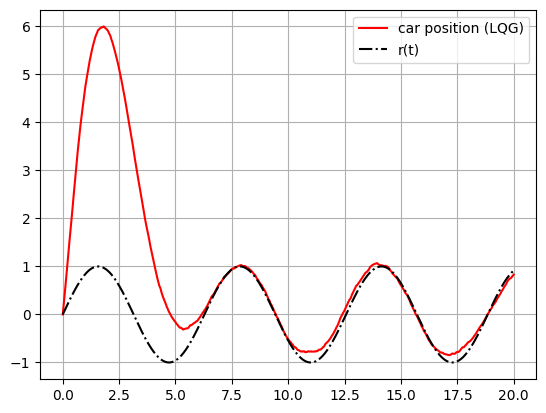

In [ ]:
plt.plot(t_lqg, x_lqg[:, 0], 'r-', label = 'car position (LQG)')
plt.plot(t, r[:, 0], 'k-.', label = 'r(t)')
plt.legend()
plt.grid()

Text(0.5, 1.0, 'Estimation Performance')

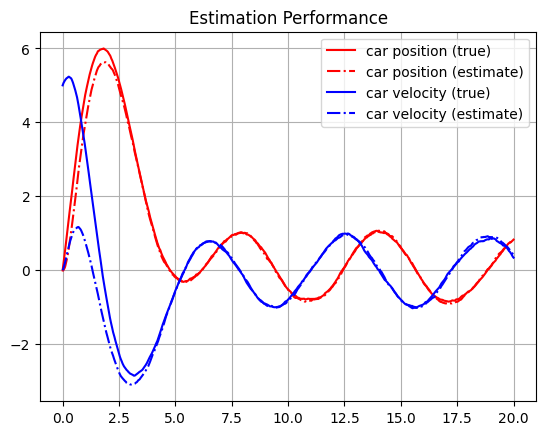

In [ ]:
plt.plot(t, x_lqg[:, 0], 'r-', label = 'car position (true)')
plt.plot(t, x_lqg[:, 0]-x_lqg[:, 2], 'r-.', label = 'car position (estimate)')
plt.plot(t, x_lqg[:, 1], 'b-', label = 'car velocity (true)')
plt.plot(t, x_lqg[:, 1]-x_lqg[:, 3], 'b-.', label = 'car velocity (estimate)')
plt.legend()
plt.grid()
plt.title('Estimation Performance')